In [3]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

# Memuat dataset
path = "/content/drive/My Drive/Colab Notebooks/DatasetofDiabetes.csv"
data = pd.read_csv(path)
# Normalize the CLASS column by stripping spaces
data['CLASS'] = data['CLASS'].str.strip()

# Check the unique values in the CLASS column after normalization to ensure correction
final_class_values = data['CLASS'].unique()
final_class_values
# Step 1: Remove duplicates
data = data.drop_duplicates()

# Step 2: Check for missing values and remove or impute them
# For simplicity, we'll remove rows with any missing value. In a more complex scenario, we might want to impute these.
data = data.dropna()

data.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,ID,No_Pation,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,CLASS
0,502,17975,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
1,735,34221,M,26,4.5,62,4.9,3.7,1.4,1.1,2.1,0.6,23.0,N
2,420,47975,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
3,680,87656,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
4,504,34223,M,33,7.1,46,4.9,4.9,1.0,0.8,2.0,0.4,21.0,N


After resampling - Features shape: (2025, 11) Labels shape: (2025, 3)
Epoch 1/50
32/32 [==============================] - 11s 81ms/step - loss: 0.5549 - accuracy: 0.6247 - val_loss: 0.3145 - val_accuracy: 0.8400
Epoch 2/50
32/32 [==============================] - 1s 25ms/step - loss: 0.4350 - accuracy: 0.6420 - val_loss: 0.2458 - val_accuracy: 0.8650
Epoch 3/50
32/32 [==============================] - 1s 27ms/step - loss: 0.3891 - accuracy: 0.6958 - val_loss: 0.2114 - val_accuracy: 0.8950
Epoch 4/50
32/32 [==============================] - 1s 26ms/step - loss: 0.3393 - accuracy: 0.7669 - val_loss: 0.1810 - val_accuracy: 0.9000
Epoch 5/50
32/32 [==============================] - 1s 26ms/step - loss: 0.2769 - accuracy: 0.8420 - val_loss: 0.1641 - val_accuracy: 0.9200
Epoch 6/50
32/32 [==============================] - 1s 36ms/step - loss: 0.2135 - accuracy: 0.8869 - val_loss: 0.1481 - val_accuracy: 0.9250
Epoch 7/50
32/32 [==============================] - 1s 47ms/step - loss: 0.1691 - a

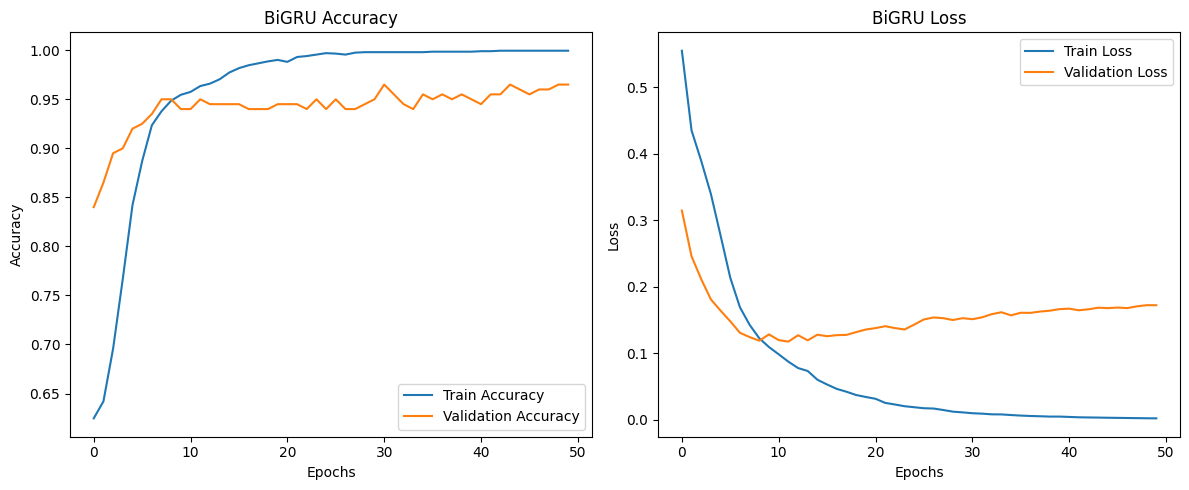

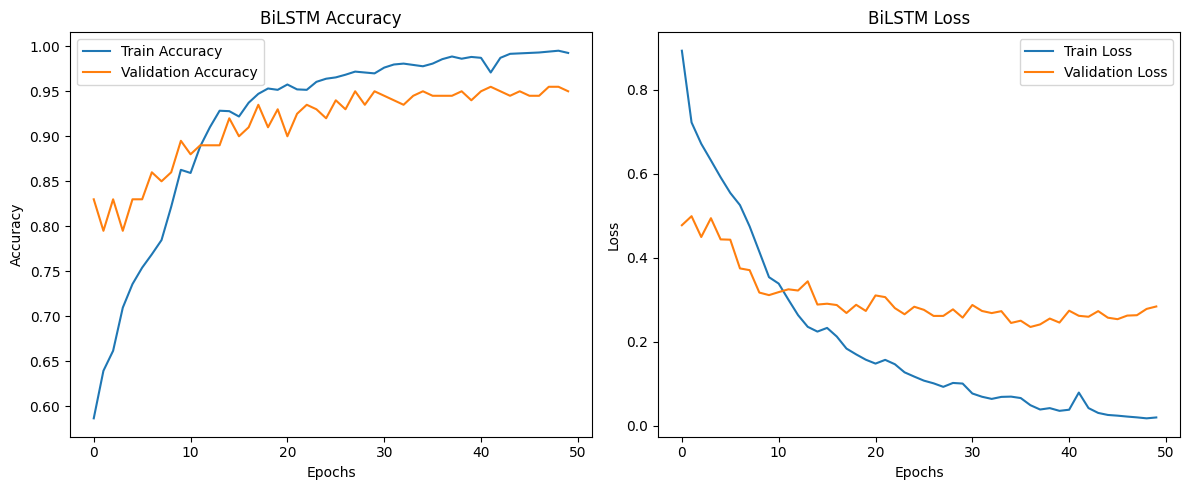

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Bidirectional, GRU, LSTM, Dense
from keras.optimizers import Adam
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

# Preprocessing data
label_encoder = LabelEncoder()
data['Gender'] = label_encoder.fit_transform(data['Gender'])
data['CLASS'] = label_encoder.fit_transform(data['CLASS'])

# Check and ensure all classes have at least two instances
for class_value, count in zip(*np.unique(data['CLASS'], return_counts=True)):
    if count < 2:
        # Optionally remove this class or add a duplicate for this example
        data = data[data['CLASS'] != class_value]  # Removing instances of this class

# Prepare features and labels
X = data.drop(['ID', 'No_Pation', 'CLASS'], axis=1)
y = data['CLASS']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
smt = SMOTETomek(random_state=42, smote=SMOTE(sampling_strategy='auto', k_neighbors=1))

X_train_resampled, y_train_resampled = smt.fit_resample(X_train, y_train)
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

y_train_encoded = to_categorical(y_train_resampled)
y_test_encoded = to_categorical(y_test)

bigru_model = Sequential([
    Bidirectional(GRU(64, return_sequences=True), input_shape=(X_train_scaled.shape[1], 1)),
    Bidirectional(GRU(32)),
    Dense(y_train_encoded.shape[1], activation='softmax')
])

print("After resampling - Features shape:", X_train_resampled.shape, "Labels shape:", y_train_encoded.shape)

bigru_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
bigru_history = bigru_model.fit(X_train_scaled, y_train_encoded, epochs=50, batch_size=64, validation_data=(X_test_scaled, y_test_encoded))

# Define BiLSTM model
bilstm_model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train_scaled.shape[1], 1)),
    Bidirectional(LSTM(32)),
    Dense(y_train_encoded.shape[1], activation='softmax')
])

# Compile and train BiLSTM
bilstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
bilstm_history = bilstm_model.fit(X_train_scaled, y_train_encoded, epochs=50, batch_size=64, validation_data=(X_test_scaled, y_test_encoded))

# Define XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
# Train XGBoost
xgb_model.fit(X_train_scaled, np.argmax(y_train_encoded, axis=1))  # XGBoost does not use one-hot encoding

# Evaluate models
bigru_accuracy = bigru_model.evaluate(X_test_scaled, y_test_encoded)
bilstm_accuracy = bilstm_model.evaluate(X_test_scaled, y_test_encoded)
xgb_accuracy = xgb_model.score(X_test_scaled, np.argmax(y_test_encoded, axis=1))

print(f"BiGRU Accuracy: {bigru_accuracy[1]}")
print(f"BiLSTM Accuracy: {bilstm_accuracy[1]}")
print(f"XGBoost Accuracy: {xgb_accuracy}")
import matplotlib.pyplot as plt

# Function to plot accuracy and loss
def plot_history(history, model_name):
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot history for BiGRU model
plot_history(bigru_history, 'BiGRU')

# Plot history for BiLSTM model
plot_history(bilstm_history, 'BiLSTM')


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, GRU, Dense
from keras.utils import to_categorical
import xgboost as xgb
from xgboost import XGBRegressor
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

label_encoder = LabelEncoder()
data['Gender'] = label_encoder.fit_transform(data['Gender'])
# Re-apply label encoding to ensure consistency
data['CLASS'] = label_encoder.fit_transform(data['CLASS'])

# Ensure no class is missing in the encoding
expected_classes = np.arange(len(np.unique(data['CLASS'])))

# Split data ensuring at least two instances per class if possible
values, counts = np.unique(data['CLASS'], return_counts=True)  # Correct unpacking
for class_value, count in zip(values, counts):  # Use the unpacked values and counts
    if count < 2:
        data = data[data['CLASS'] != class_value]  # Optionally remove classes with less than 2 instances

X = data.drop(['ID', 'No_Pation', 'CLASS'], axis=1)
y = data['CLASS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

# Ensure y_train covers expected class labels
if not np.all(np.isin(expected_classes, np.unique(y_train))):
    raise ValueError(f"y_train does not include all expected classes: {expected_classes}")

# Initialize and train XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_scaled, y_train)

bigru_model = Sequential([
    Bidirectional(GRU(64, return_sequences=True), input_shape=(X_train_scaled.shape[1], 1)),
    Bidirectional(GRU(32)),
    Dense(y_train_encoded.shape[1], activation='softmax')
])
bigru_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
bigru_history = bigru_model.fit(X_train_scaled, y_train_encoded, epochs=50, batch_size=64, validation_data=(X_test_scaled, y_test_encoded))

bilstm_model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train_scaled.shape[1], 1)),
    Bidirectional(LSTM(32)),
    Dense(y_train_encoded.shape[1], activation='softmax')
])
bilstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
bilstm_history = bilstm_model.fit(X_train_scaled, y_train_encoded, epochs=50, batch_size=64, validation_data=(X_test_scaled, y_test_encoded))

bigru_probs = bigru_model.predict(X_test_scaled)
bilstm_probs = bilstm_model.predict(X_test_scaled)
xgb_probs = xgb_model.predict_proba(X_test_scaled)[:, 1]

stacked_features = np.column_stack((bigru_probs, bilstm_probs, xgb_probs))
meta_model = XGBRegressor()
meta_model.fit(stacked_features, y_test)
final_predictions = np.round(meta_model.predict(stacked_features)).astype(int)

final_accuracy = accuracy_score(y_test, final_predictions)
final_accuracy_formatted = "{:.10f}".format(final_accuracy)
print(f"Final Stacked Model Accuracy: {final_accuracy_formatted}")


Epoch 1/50
13/13 [==============================] - 12s 160ms/step - loss: 0.6229 - accuracy: 0.7372 - val_loss: 0.5049 - val_accuracy: 0.8600
Epoch 2/50
13/13 [==============================] - 0s 28ms/step - loss: 0.3521 - accuracy: 0.8748 - val_loss: 0.2036 - val_accuracy: 0.8400
Epoch 3/50
13/13 [==============================] - 0s 28ms/step - loss: 0.1995 - accuracy: 0.8536 - val_loss: 0.1713 - val_accuracy: 0.8800
Epoch 4/50
13/13 [==============================] - 0s 29ms/step - loss: 0.1721 - accuracy: 0.8798 - val_loss: 0.1580 - val_accuracy: 0.9000
Epoch 5/50
13/13 [==============================] - 0s 28ms/step - loss: 0.1571 - accuracy: 0.8899 - val_loss: 0.1504 - val_accuracy: 0.8950
Epoch 6/50
13/13 [==============================] - 0s 28ms/step - loss: 0.1459 - accuracy: 0.8961 - val_loss: 0.1429 - val_accuracy: 0.8950
Epoch 7/50
13/13 [==============================] - 0s 28ms/step - loss: 0.1381 - accuracy: 0.8999 - val_loss: 0.1361 - val_accuracy: 0.9050
Epoch 8/50


Epoch 1/50
38/38 [==============================] - 10s 67ms/step - loss: 0.5259 - accuracy: 0.5068 - val_loss: 0.4837 - val_accuracy: 0.0000e+00
Epoch 2/50
38/38 [==============================] - 1s 26ms/step - loss: 0.3758 - accuracy: 0.6511 - val_loss: 0.2396 - val_accuracy: 1.0000
Epoch 3/50
38/38 [==============================] - 1s 26ms/step - loss: 0.2972 - accuracy: 0.7569 - val_loss: 0.0803 - val_accuracy: 1.0000
Epoch 4/50
38/38 [==============================] - 2s 41ms/step - loss: 0.2230 - accuracy: 0.8384 - val_loss: 0.0562 - val_accuracy: 1.0000
Epoch 5/50
38/38 [==============================] - 2s 47ms/step - loss: 0.1782 - accuracy: 0.8814 - val_loss: 0.0769 - val_accuracy: 1.0000
Epoch 6/50
38/38 [==============================] - 1s 36ms/step - loss: 0.1482 - accuracy: 0.9029 - val_loss: 0.0336 - val_accuracy: 1.0000
Epoch 7/50
38/38 [==============================] - 1s 25ms/step - loss: 0.1229 - accuracy: 0.9281 - val_loss: 0.0267 - val_accuracy: 1.0000
Epoch 8/

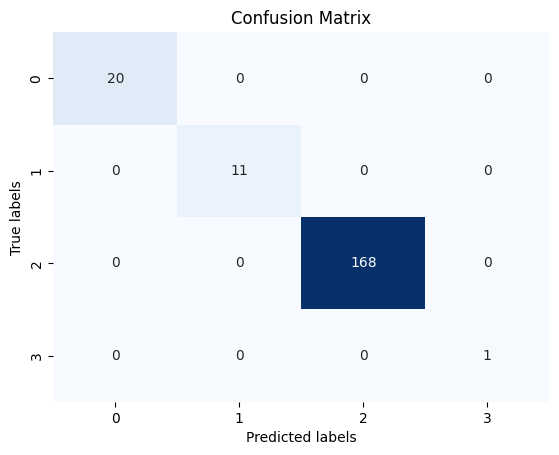

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, GRU, Dense
from keras.utils import to_categorical
import xgboost as xgb
from xgboost import XGBRegressor
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

# Load and preprocess data
label_encoder = LabelEncoder()
data['Gender'] = label_encoder.fit_transform(data['Gender'])
data['CLASS'] = label_encoder.fit_transform(data['CLASS'])

# Remove classes with less than 3 instances or merge them before splitting
class_counts = data['CLASS'].value_counts()
data = data[data['CLASS'].isin(class_counts[class_counts >= 3].index)]

# Split data
X_train, X_test, y_train, y_test = train_test_split(data.drop(['ID', 'No_Pation', 'CLASS'], axis=1), data['CLASS'], test_size=0.2, random_state=42, stratify=data['CLASS'])

# Apply SMOTE-Tomek links to the training data to handle imbalance
smt = SMOTETomek(smote=SMOTE(k_neighbors=2))  # Reduce k_neighbors if necessary
X_train_resampled, y_train_resampled = smt.fit_resample(X_train, y_train)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Define and compile models
bigru_model = Sequential([
    Bidirectional(GRU(64, return_sequences=True), input_shape=(X_train_scaled.shape[1], 1)),
    Bidirectional(GRU(32)),
    Dense(y_train_resampled.max()+1, activation='softmax')
])
bigru_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

bilstm_model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train_scaled.shape[1], 1)),
    Bidirectional(LSTM(32)),
    Dense(y_train_resampled.max()+1, activation='softmax')
])
bilstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train models and predict
bigru_model.fit(X_train_scaled, to_categorical(y_train_resampled), epochs=50, batch_size=64, validation_split=0.1)
bilstm_model.fit(X_train_scaled, to_categorical(y_train_resampled), epochs=50, batch_size=64, validation_split=0.1)

bigru_probs = bigru_model.predict(X_test_scaled)
bilstm_probs = bilstm_model.predict(X_test_scaled)
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_scaled, y_train_resampled)
xgb_probs = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Stack features and train meta-model
stacked_features = np.column_stack((bigru_probs.max(axis=1), bilstm_probs.max(axis=1), xgb_probs))
meta_model = XGBRegressor()
meta_model.fit(stacked_features, y_test)
final_predictions = np.round(meta_model.predict(stacked_features)).astype(int)

# Evaluation
conf_mat = confusion_matrix(y_test, final_predictions)
print("Confusion Matrix:\n", conf_mat)
print("Classification Report:\n", classification_report(y_test, final_predictions))

# Plot confusion matrix
sns.heatmap(conf_mat, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


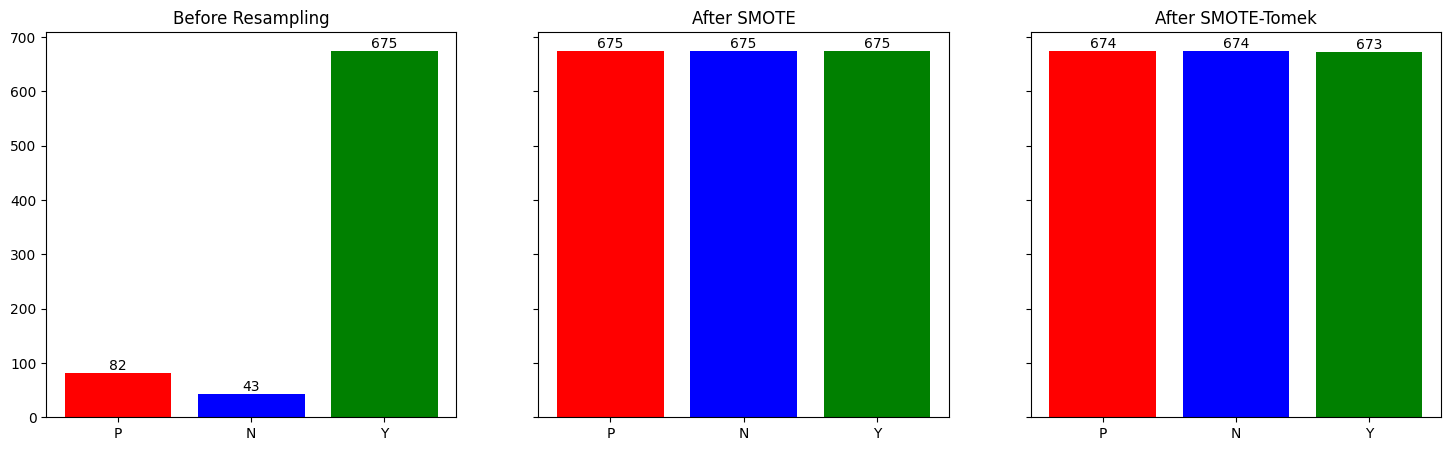

Epoch 1/50
29/29 [==============================] - 13s 95ms/step - loss: 0.5551 - accuracy: 0.6568 - val_loss: 0.8292 - val_accuracy: 0.0000e+00
Epoch 2/50
29/29 [==============================] - 1s 26ms/step - loss: 0.4113 - accuracy: 0.7057 - val_loss: 0.6709 - val_accuracy: 0.2562
Epoch 3/50
29/29 [==============================] - 1s 27ms/step - loss: 0.3643 - accuracy: 0.7481 - val_loss: 0.5995 - val_accuracy: 0.5025
Epoch 4/50
29/29 [==============================] - 1s 26ms/step - loss: 0.3200 - accuracy: 0.7893 - val_loss: 0.5220 - val_accuracy: 0.5911
Epoch 5/50
29/29 [==============================] - 1s 26ms/step - loss: 0.2616 - accuracy: 0.8465 - val_loss: 0.3770 - val_accuracy: 0.7291
Epoch 6/50
29/29 [==============================] - 1s 27ms/step - loss: 0.2008 - accuracy: 0.8933 - val_loss: 0.2715 - val_accuracy: 0.8966
Epoch 7/50
29/29 [==============================] - 1s 28ms/step - loss: 0.1682 - accuracy: 0.9147 - val_loss: 0.2721 - val_accuracy: 0.8719
Epoch 8/

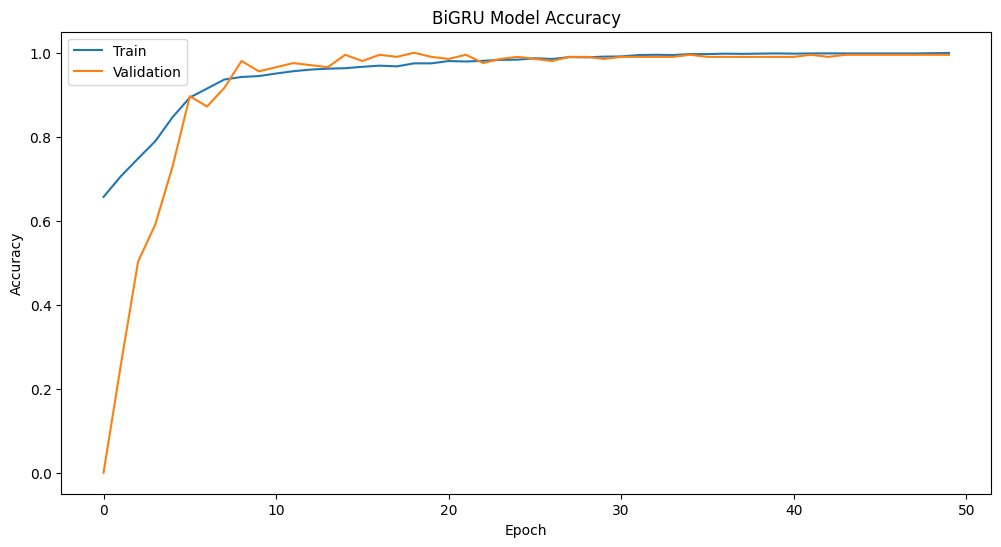

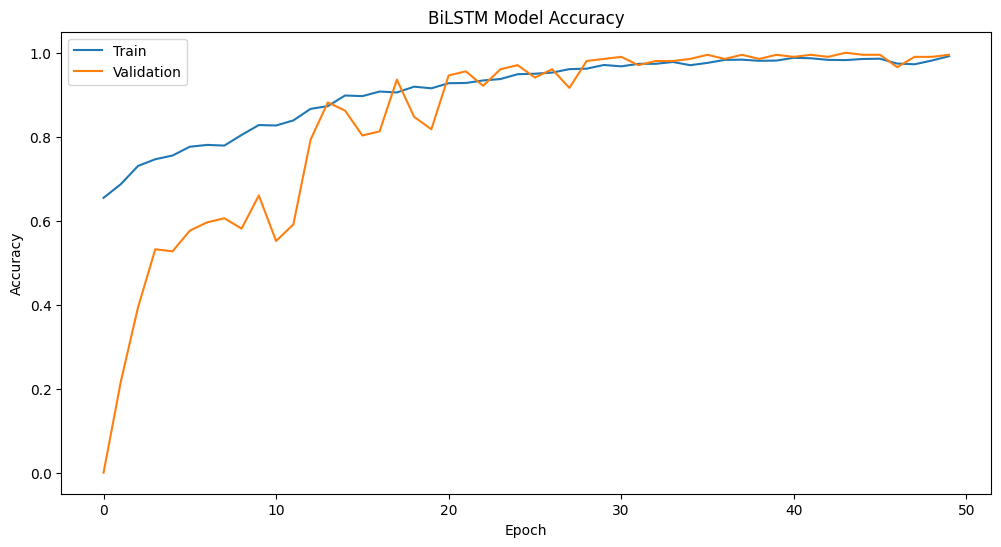

Accuracy of the XGBoost model: 0.99
7/7 [==============================] - 2s 7ms/step
Confusion Matrix:
 [[ 21   0   0]
 [  0  10   0]
 [  0   0 169]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00       169

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



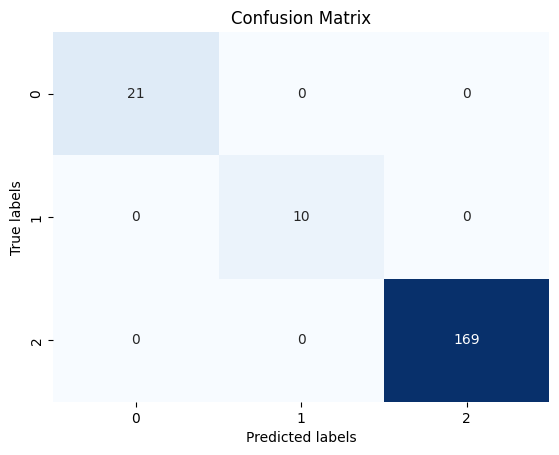

In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, GRU, Dense
from keras.utils import to_categorical
import xgboost as xgb
from xgboost import XGBRegressor
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

# Load and preprocess data
label_encoder = LabelEncoder()
data['Gender'] = label_encoder.fit_transform(data['Gender'])
data['CLASS'] = label_encoder.fit_transform(data['CLASS'])

# Remove classes with fewer than 3 instances
class_counts = data['CLASS'].value_counts()
data = data[data['CLASS'].isin(class_counts[class_counts >= 3].index)]

# Split data
X_train, X_test, y_train, y_test = train_test_split(data.drop(['ID', 'No_Pation', 'CLASS'], axis=1), data['CLASS'], test_size=0.2, random_state=42, stratify=data['CLASS'])

# Applying SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Applying SMOTE-Tomek
smt = SMOTETomek(smote=SMOTE(k_neighbors=2))
X_train_resampled, y_train_resampled = smt.fit_resample(X_train, y_train)

# Count instances
values_before, counts_before = np.unique(y_train, return_counts=True)
values_smote, counts_smote = np.unique(y_train_smote, return_counts=True)
values_smt, counts_smt = np.unique(y_train_resampled, return_counts=True)

# Plotting
fig, ax = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Adjust class names for three classes
class_names = ['P', 'N', 'Y']  # Adjust based on your data and label encoder order

ax[0].bar(class_names, counts_before, color=['red', 'blue', 'green'])
ax[0].set_title('Before Resampling')
for i, count in enumerate(counts_before):
    ax[0].text(i, count + 5, str(count), ha='center')

ax[1].bar(class_names, counts_smote, color=['red', 'blue', 'green'])
ax[1].set_title('After SMOTE')
for i, count in enumerate(counts_smote):
    ax[1].text(i, count + 5, str(count), ha='center')

ax[2].bar(class_names, counts_smt, color=['red', 'blue', 'green'])
ax[2].set_title('After SMOTE-Tomek')
for i, count in enumerate(counts_smt):
    ax[2].text(i, count + 5, str(count), ha='center')

plt.show()

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Define and compile models
bigru_model = Sequential([
    Bidirectional(GRU(64, return_sequences=True), input_shape=(X_train_scaled.shape[1], 1)),
    Bidirectional(GRU(32)),
    Dense(y_train_resampled.max()+1, activation='softmax')
])
bigru_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

bilstm_model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train_scaled.shape[1], 1)),
    Bidirectional(LSTM(32)),
    Dense(y_train_resampled.max()+1, activation='softmax')
])
bilstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train models
bigru_history = bigru_model.fit(X_train_scaled, to_categorical(y_train_resampled), epochs=50, batch_size=64, validation_split=0.1)
bilstm_history = bilstm_model.fit(X_train_scaled, to_categorical(y_train_resampled), epochs=50, batch_size=64, validation_split=0.1)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(bigru_history.history['accuracy'])
plt.plot(bigru_history.history['val_accuracy'])
plt.title('BiGRU Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(bilstm_history.history['accuracy'])
plt.plot(bilstm_history.history['val_accuracy'])
plt.title('BiLSTM Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_scaled, y_train_resampled)
# Make predictions
xgb_predictions = xgb_model.predict(X_test_scaled)

# Calculate accuracy
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
print(f"Accuracy of the XGBoost model: {xgb_accuracy:.2f}")

# Predictions for ensemble
bigru_probs = bigru_model.predict(X_test_scaled)
bilstm_probs = bilstm_model.predict(X_test_scaled)
xgb_probs = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Stack features and train meta-model
stacked_features = np.column_stack((bigru_probs.max(axis=1), bilstm_probs.max(axis=1), xgb_probs))
meta_model = XGBRegressor()
meta_model.fit(stacked_features, y_test)
final_predictions = np.round(meta_model.predict(stacked_features)).astype(int)

# Evaluation
conf_mat = confusion_matrix(y_test, final_predictions)
print("Confusion Matrix:\n", conf_mat)
print("Classification Report:\n", classification_report(y_test, final_predictions))

# Plot confusion matrix
sns.heatmap(conf_mat, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
